2025-03-08 15:20:32.259995: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-03-08 15:20:32.261154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-03-08 15:20:32.261732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 268ms/step


2025-03-08 15:20:33.175505: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-03-08 15:20:33.176181: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-03-08 15:20:33.176636: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Predicted next closing price for ORCL: $171.42


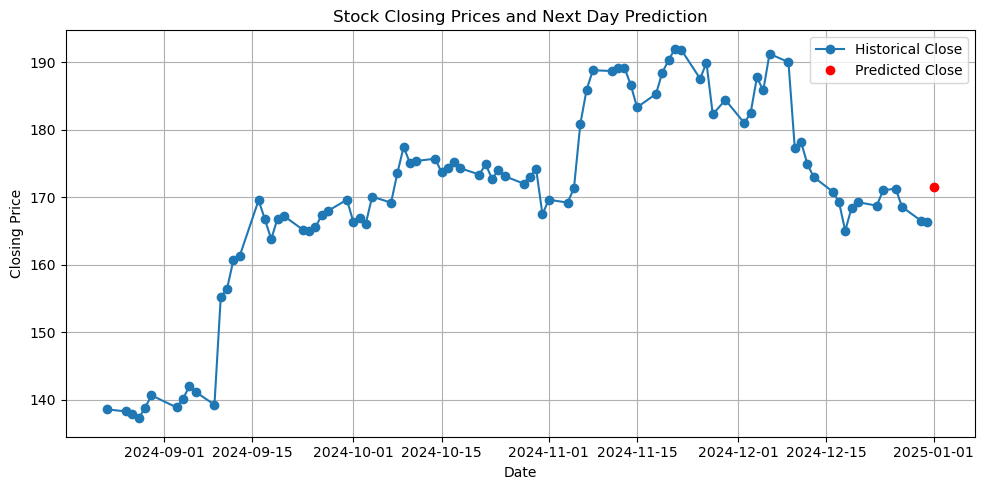

In [1]:
import mysql.connector
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from datetime import datetime
from tensorflow.keras.models import load_model

# Database connection configuration
db_config = {
    'host': '192.168.0.17',
    'user': 'admin',
    'password': 'spotify',
    'database': 'stocks'
}

def load_model_and_objects(ticker):
    """Load the saved LSTM model, scaler, and look_back parameter for the given ticker."""
    model = load_model(f'{ticker}_lstm_model.h5')
    
    with open(f'{ticker}_scaler.pkl', 'rb') as scaler_file:
        scaler = pickle.load(scaler_file)
    
    with open(f'{ticker}_look_back.pkl', 'rb') as lb_file:
        look_back = pickle.load(lb_file)
    
    return model, scaler, look_back

def fetch_recent_data(ticker, look_back, extra_days=30):
    """
    Fetch recent stock data for the given ticker.
    Retrieves enough data to fill the look_back window and extra days for plotting.
    """
    # Query to retrieve the latest data (we add extra_days to show context)
    query = f"""
        SELECT Date_ AS date, Close_ AS close
        FROM {ticker}_stock_data
        ORDER BY Date_ DESC
        LIMIT {look_back + extra_days};
    """
    
    # Connect to the database, fetch data, then close connection
    conn = mysql.connector.connect(**db_config)
    df = pd.read_sql(query, conn)
    conn.close()
    
    # Convert date column to datetime and sort in ascending order
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values('date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    return df

def predict_next_close(model, scaler, data, look_back):
    """
    Use the model to predict the next day's closing price.
    Data should be a DataFrame with at least look_back rows.
    """
    # Ensure we have enough data for prediction
    if len(data) < look_back:
        raise ValueError("Not enough data to make a prediction.")
    
    # Use only the closing prices and scale them
    last_data = data['close'].values[-look_back:].reshape(-1, 1)
    scaled_last_data = scaler.transform(last_data)
    
    # Reshape to match LSTM input: [samples, time steps, features]
    X = np.reshape(scaled_last_data, (1, look_back, 1))
    
    # Predict the next scaled value and invert scaling
    scaled_prediction = model.predict(X)
    predicted_price = scaler.inverse_transform(scaled_prediction)[0][0]
    
    return predicted_price

def plot_prediction(df, predicted_price):
    """
    Plot historical closing prices and the predicted next closing price.
    The predicted point is appended to the historical data with a simulated next date.
    """
    # Use the last date in the dataset and assume the next trading day (this is a simplification)
    last_date = df['date'].iloc[-1]
    next_date = last_date + pd.Timedelta(days=1)
    
    # Plot historical data
    plt.figure(figsize=(10,5))
    plt.plot(df['date'], df['close'], label="Historical Close", marker='o')
    
    # Plot the predicted point
    plt.plot(next_date, predicted_price, 'ro', label="Predicted Close")
    plt.title("Stock Closing Prices and Next Day Prediction")
    plt.xlabel("Date")
    plt.ylabel("Closing Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def main():
    # Get ticker symbol from user
    ticker = input("Enter the ticker symbol (e.g., AAPL, ORCL): ").strip().upper()
    
    # Load the model, scaler, and look_back value for the ticker
    model, scaler, look_back = load_model_and_objects(ticker)
    
    # Fetch recent data for prediction and plotting
    df = fetch_recent_data(ticker, look_back, extra_days=30)
    
    # Predict the next day's closing price
    predicted_price = predict_next_close(model, scaler, df, look_back)
    print(f"Predicted next closing price for {ticker}: ${predicted_price:.2f}")
    
    # Plot historical data and the predicted point
    plot_prediction(df, predicted_price)

if __name__ == "__main__":
    main()